# Proyecto Integrador IV
> E-Commerce Data Pipeline

En este notebook, primero ejecutaremos todos los componentes de nuestro pipeline ELT y luego realizaremos visualizaciones con la información resultante


In [3]:
import importlib

libraries = [
    "black", "matplotlib", "pandas", "plotly.express", "requests",
    "seaborn", "sqlalchemy", "nbformat", "pytest"
]

for lib in libraries:
    try:
        importlib.import_module(lib)
        print(f"✅ {lib} está instalado")
    except ImportError:
        print(f"❌ {lib} NO está instalado")


✅ black está instalado
✅ matplotlib está instalado
✅ pandas está instalado
✅ plotly.express está instalado
✅ requests está instalado
✅ seaborn está instalado
✅ sqlalchemy está instalado
✅ nbformat está instalado
✅ pytest está instalado


In [4]:
# Importing the necessary libraries
from pandas import DataFrame
from sqlalchemy import create_engine
from typing import Dict
from pathlib import Path

from src.transform import QueryEnum
from src import config
from src.transform import run_queries
from src.extract import extract
from src.load import load
from src.plots import (
    plot_freight_value_weight_relationship,
    plot_global_amount_order_status,
    plot_real_vs_predicted_delivered_time,
    plot_revenue_by_month_year,
    plot_revenue_per_state,
    plot_top_10_least_revenue_categories,
    plot_top_10_revenue_categories,
    plot_top_10_revenue_categories_ammount,
    plot_delivery_date_difference,
    plot_order_amount_per_day_with_holidays,
)

In [5]:
# Create the database sql file
Path(config.SQLITE_BD_ABSOLUTE_PATH).touch()

# Create the database connection
ENGINE = create_engine(rf"sqlite:///{config.SQLITE_BD_ABSOLUTE_PATH}", echo=False)

### 1. Extract

Aquí estarás extrayendo la información de las fuentes.

In [6]:
csv_folder = config.DATASET_ROOT_PATH
public_holidays_url = config.PUBLIC_HOLIDAYS_URL

# 1. Get the mapping of the csv files to the table names.
csv_table_mapping = config.get_csv_to_table_mapping()

# 2. Extract the data from the csv files, holidays and load them into the dataframes.
csv_dataframes = extract(csv_folder, csv_table_mapping, public_holidays_url)

https://date.nager.at/api/v3/publicholidays/2017/BR


### 2. Load

Usando los diferentes conjuntos de datos proporcionados, almacenarás todo en nuestro Data Warehouse.

In [7]:
print(ENGINE)
load(data_frames=csv_dataframes, database=ENGINE)

Engine(sqlite:///c:\Users\Luisa Carvajal\OneDrive\Documentos\Actividades_U\Semestre_9\Proyecto_Integrador_4\proyecto_integrador\olist.db)
Datos cargados en la tabla: olist_customers
Datos cargados en la tabla: olist_geolocation
Datos cargados en la tabla: olist_order_items
Datos cargados en la tabla: olist_order_payments
Datos cargados en la tabla: olist_order_reviews
Datos cargados en la tabla: olist_orders
Datos cargados en la tabla: olist_products
Datos cargados en la tabla: olist_sellers
Datos cargados en la tabla: product_category_name_translation
Datos cargados en la tabla: public_holidays


### 3. Transform

Aquí transformarás las diferentes consultas en tablas. Hay dos secciones: una con las consultas relacionadas con los ingresos y otra con las consultas relacionadas con las entregas.

##### 3.1 Queries sobre ingresos

In [8]:
query_results: Dict[str, DataFrame] = run_queries(database=ENGINE)

In [17]:
# Transforming the revenue_by_month_year query to a table
revenue_by_month_year = query_results[QueryEnum.REVENUE_BY_MONTH_YEAR.value]
revenue_by_month_year

,month_no,month,Year2016,Year2017,Year2018
0,10,Oct,46653.74,6921535.24,8451584.77


In [18]:
# Transforming the top_10_revenue_categories query to a table
top_10_revenue_categories = query_results[QueryEnum.TOP_10_REVENUE_CATEGORIES.value]
top_10_revenue_categories

,Category,Num_order,Revenue
0,bed_bath_table,9272,1692714.28
1,health_beauty,8646,1620684.04
2,computers_accessories,6529,1549252.47
3,furniture_decor,6307,1394466.93
4,watches_gifts,5493,1387046.31
5,sports_leisure,7529,1349252.93
6,housewares,5743,1069787.97
7,auto,3809,833610.84
8,garden_tools,3448,810614.93
9,cool_stuff,3559,744649.32


In [19]:
# Transforming the top_10_least_revenue_categories query to a table
top_10_least_revenue_categories = query_results[
    QueryEnum.TOP_10_LEAST_REVENUE_CATEGORIES.value
]
top_10_least_revenue_categories

,Category,Num_order,Revenue
0,security_and_services,2,324.51
1,fashion_childrens_clothes,7,718.98
2,cds_dvds_musicals,12,1199.43
3,home_comfort_2,24,1710.54
4,flowers,29,2213.01
5,arts_and_craftmanship,23,2326.17
6,la_cuisine,13,2913.53
7,fashion_sport,26,3605.83
8,diapers_and_hygiene,25,4126.17
9,fashio_female_clothing,36,4902.67


In [20]:
# Transforming the revenue_per_state query to a table
revenue_per_state = query_results[QueryEnum.REVENUE_PER_STATE.value]
revenue_per_state

,customer_state,Revenue
0,SP,5769081.27
1,RJ,2055690.45
2,MG,1819277.61
3,RS,861608.40
4,PR,781919.55
5,SC,595208.40
6,BA,591270.60
7,DF,346146.17
8,GO,334294.22
9,ES,317682.65


##### 3.2 Queries sobre entregas

In [21]:
# Transforming the delivery_date_difference query to a table
delivery_date_difference = query_results[QueryEnum.DELIVERY_DATE_DIFFERECE.value]
delivery_date_difference

,State,Delivery_Difference
0,AL,8
1,MA,9
2,BA,10
3,CE,10
4,ES,10
5,SE,10
6,MS,11
7,PI,11
8,RJ,11
9,SC,11


In [22]:
# Transforming the real vs predicted delivered time query to a table per month and year
real_vs_estimated_delivered_time = query_results[
    QueryEnum.REAL_VS_ESTIMATED_DELIVERED_TIME.value
]
real_vs_estimated_delivered_time

,month_no,month,Year2016_real_time,Year2017_real_time,Year2018_real_time,Year2016_estimated_time,Year2017_estimated_time,Year2018_estimated_time
0,01,Jan,NaN,12.647044,14.080563,NaN,39.508831,26.302555
1,02,Feb,NaN,13.168825,16.945138,NaN,31.848929,24.528996
2,03,Mar,NaN,12.951184,16.301410,NaN,24.732386,22.033067
3,04,Apr,NaN,14.917913,11.499241,NaN,27.349810,23.679546
4,05,May,NaN,11.322363,11.419029,NaN,24.284784,22.891488
5,06,Jun,NaN,12.011573,9.239216,NaN,24.021864,27.772740
6,07,Jul,NaN,11.592732,8.958636,NaN,23.317316,19.690127
7,08,Aug,NaN,11.147125,7.732780,NaN,23.480603,15.186330
8,09,Sep,54.813194,11.851007,NaN,18.488449,22.437366,NaN
9,10,Oct,19.600559,11.856700,NaN,55.676632,23.019536,NaN


In [37]:
# Transforming the global ammount of order status query to a table
global_ammount_order_status = query_results[QueryEnum.GLOBAL_AMMOUNT_ORDER_STATUS.value]
global_ammount_order_status

,order_status,Ammount
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


In [ ]:
orders_per_day_and_holidays = query_results[
    QueryEnum.ORDERS_PER_DAY_AND_HOLIDAYS_2017.value
]
orders_per_day_and_holidays

,order_count,date,holiday
order_purchase_timestamp,,,
2017-01-05,32,2017-01-05,False
2017-01-06,4,2017-01-06,False
2017-01-07,4,2017-01-07,False
2017-01-08,6,2017-01-08,False
2017-01-09,5,2017-01-09,False
...,...,...,...
2017-12-26,168,2017-12-26,False
2017-12-27,167,2017-12-27,False
2017-12-28,146,2017-12-28,False


In [24]:
freight_value_weight_relationship = query_results[
    QueryEnum.GET_FREIGHT_VALUE_WEIGHT_RELATIONSHIP.value
]

### 4. Graficas de las tablas resultantes

Ahora, crearemos gráficos a partir de las diferentes consultas.

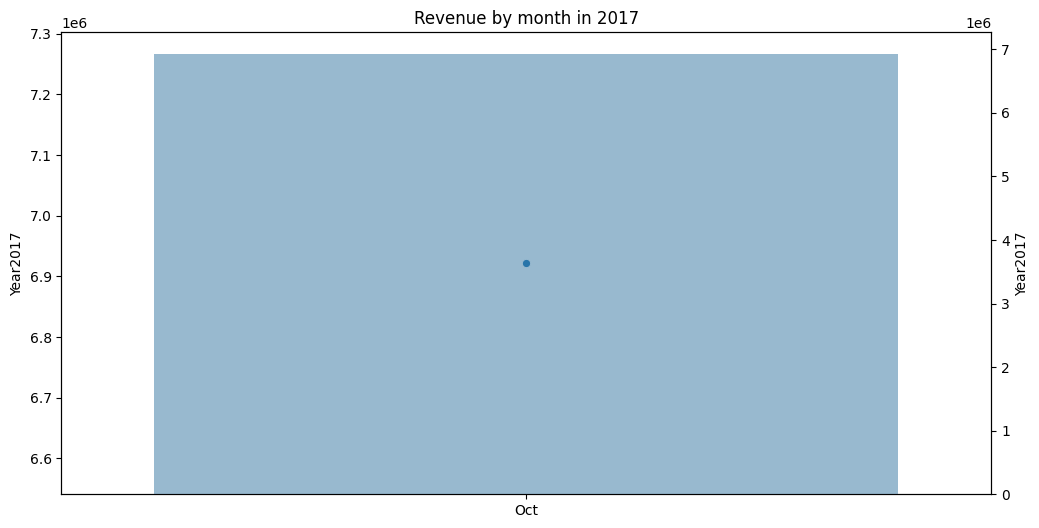

In [39]:
plot_revenue_by_month_year(revenue_by_month_year, 2017)

In [26]:
plot_top_10_revenue_categories(top_10_revenue_categories)

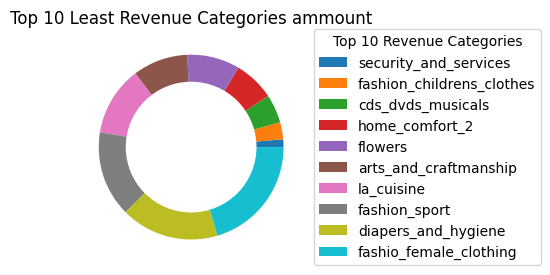

In [27]:
plot_top_10_least_revenue_categories(top_10_least_revenue_categories)

In [28]:
plot_revenue_per_state(revenue_per_state)

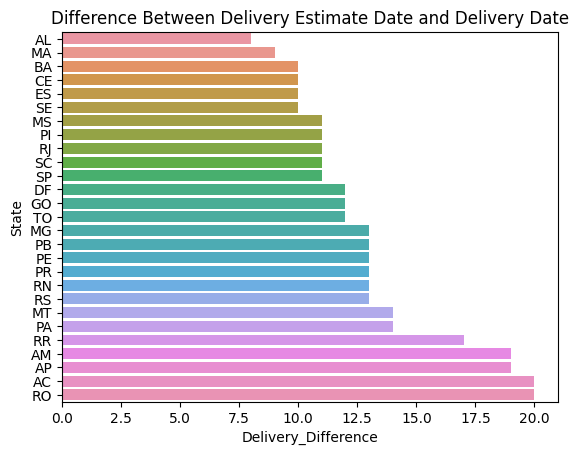

In [29]:
plot_delivery_date_difference(delivery_date_difference)

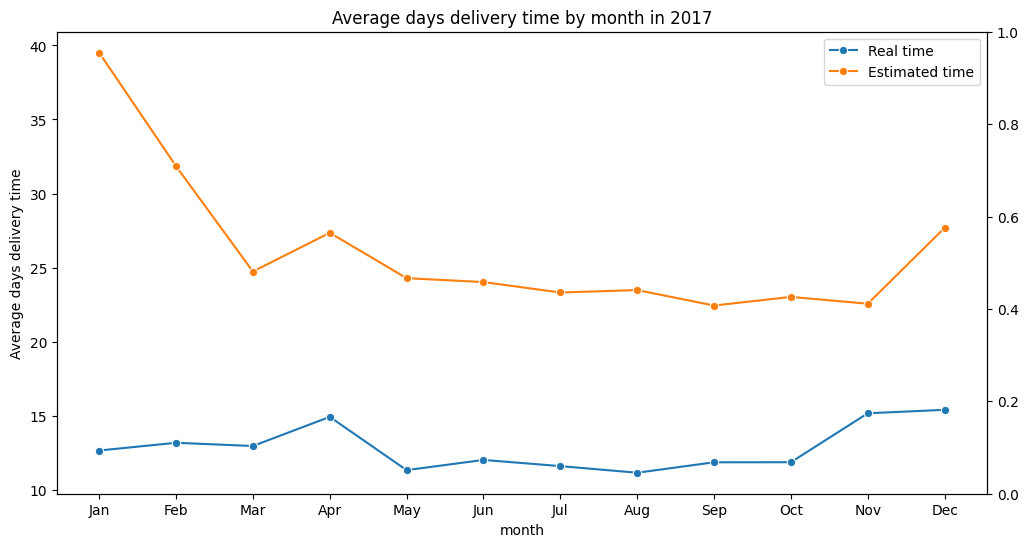

In [30]:
plot_real_vs_predicted_delivered_time(real_vs_estimated_delivered_time, year=2017)

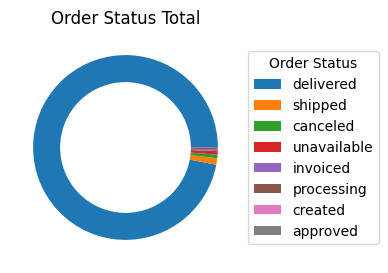

In [38]:
plot_global_amount_order_status(global_ammount_order_status)

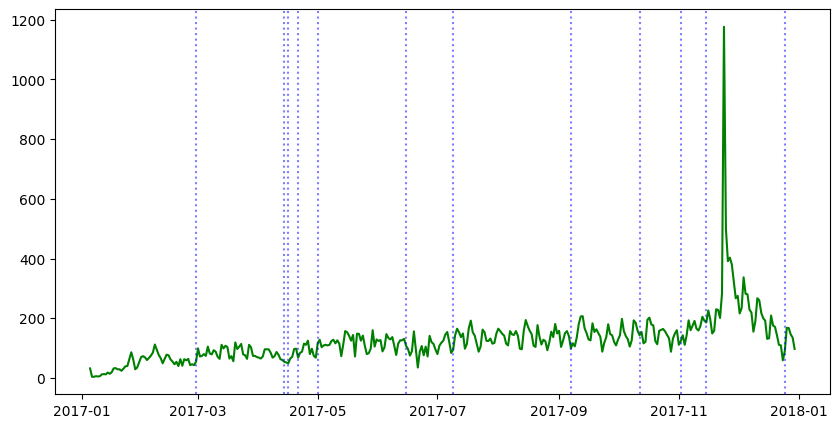

In [ ]:
plot_order_amount_per_day_with_holidays(orders_per_day_and_holidays)

El gráfico de Pedidos por Día y Días Festivos que programarás en **src/plots.py** debe ser similar a este:

![The plot you will code will be similar to this:](images/orders_per_day_and_holidays.png "Orders per Day and Holidays")

4.1 ¿Ves alguna relación entre los días festivos en Brasil durante 2017 y las compras de ese año?

Respuesta: ________

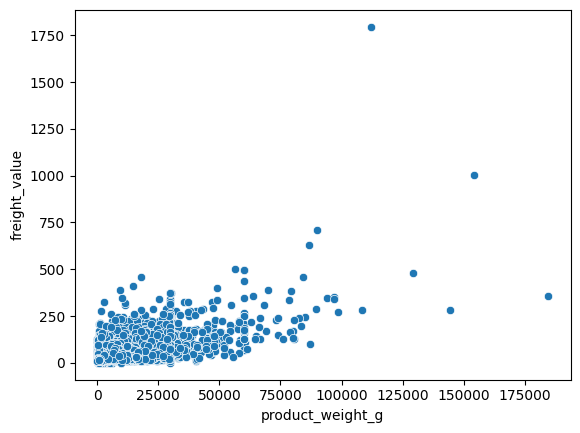

In [ ]:
plot_freight_value_weight_relationship(freight_value_weight_relationship)

El gráfico sobre la relación entre el valor del flete y el peso del producto que debes programar en `src/plots.py` tiene que ser similar a este:

![The plot you will code will be similar to this:](images/freight_value_weight_relationship.png "Freight Value and Weight Relationship")

4.2 ¿Ves alguna correlación entre el valor del flete y el peso del producto?

Respuesta:____